<a href="https://colab.research.google.com/github/rutavshah/CSC413_Project/blob/main/CSC413_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Re-implementation of VAE-GANs, VAEs, GANs inspired by [Autoencoding beyond pixels using a learned similarity metric](https://arxiv.org/pdf/1512.09300.pdf).

Used and expanded code from [this implementation of VAE-GANs based on the above paper](https://github.com/rishabhd786/VAE-GAN-PYTORCH).

# Importing in MNIST Dataset

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def dataloader(batch_size):
  dataroot="/content/drive/My Drive/mnist"
  transform=transforms.Compose([ transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
  dataset=torchvision.datasets.MNIST(root=dataroot, train=True, transform=transform, download=True)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return data_loader

def dataloader_translated(batch_size):
  dataroot="/content/drive/My Drive/mnist_translated"
  transform=transforms.Compose([ transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),transforms.Normalize((0.5),(0.5)), transforms.RandomAffine(0, translate=(0.1,0.1))])
  dataset=torchvision.datasets.MNIST(root=dataroot, train=True, transform=transform, download=True)
  data_loader2 = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return data_loader2



# Utils

In [ ]:
from torchvision.utils import make_grid , save_image
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    # f = "./%s.png" % file_name
    fig = plt.figure(dpi=200)
    fig.suptitle(file_name, fontsize=14, fontweight='bold')
    plt.imshow(npimg)
    # plt.imsave(f,npimg)
def plot_loss(loss_list):
    plt.figure(figsize=(10,5))
    plt.title("Loss During Training")
    plt.plot(loss_list,label="Loss")
    
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Decoder, Encoder/Generator, Discriminator

In [ ]:
import torch
import torch.nn as nn

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.conv1=nn.Conv2d(1,64,5,padding=2,stride=2)   #in_channels=3
    self.bn1=nn.BatchNorm2d(64,momentum=0.9)
    self.conv2=nn.Conv2d(64,128,5,padding=2,stride=2)
    self.bn2=nn.BatchNorm2d(128,momentum=0.9)
    self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
    self.bn3=nn.BatchNorm2d(256,momentum=0.9)
    self.relu=nn.LeakyReLU(0.2)
    self.fc1=nn.Linear(256*8*8,2048)
    self.bn4=nn.BatchNorm1d(2048,momentum=0.9)
    self.fc_mean=nn.Linear(2048,128)
    self.fc_logvar=nn.Linear(2048,128)   #latent dim=128
  
  def forward(self,x):
    batch_size=x.size()[0]
    out=self.relu(self.bn1(self.conv1(x)))
    out=self.relu(self.bn2(self.conv2(out)))
    out=self.relu(self.bn3(self.conv3(out)))
    out=out.view(batch_size,-1)
    out=self.relu(self.bn4(self.fc1(out)))
    mean=self.fc_mean(out)
    logvar=self.fc_logvar(out)
    
    return mean,logvar
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.fc1=nn.Linear(128,8*8*256)
    self.bn1=nn.BatchNorm1d(8*8*256,momentum=0.9)
    self.relu=nn.LeakyReLU(0.2)
    self.deconv1=nn.ConvTranspose2d(256,256,6, stride=2, padding=2)
    self.bn2=nn.BatchNorm2d(256,momentum=0.9)
    self.deconv2=nn.ConvTranspose2d(256,128,6, stride=2, padding=2)
    self.bn3=nn.BatchNorm2d(128,momentum=0.9)
    self.deconv3=nn.ConvTranspose2d(128,32,6, stride=2, padding=2)
    self.bn4=nn.BatchNorm2d(32,momentum=0.9)
    self.deconv4=nn.ConvTranspose2d(32,1,5, stride=1, padding=2)
    self.tanh=nn.Tanh()

  def forward(self,x):
    batch_size=x.size()[0]
    x=self.relu(self.bn1(self.fc1(x)))
    x=x.view(-1,256,8,8)
    x=self.relu(self.bn2(self.deconv1(x)))
    x=self.relu(self.bn3(self.deconv2(x)))
    x=self.relu(self.bn4(self.deconv3(x)))
    x=self.tanh(self.deconv4(x))
    return x
    
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1=nn.Conv2d(1,32,5,padding=2,stride=1)
    self.relu=nn.LeakyReLU(0.2)
    self.conv2=nn.Conv2d(32,128,5,padding=2,stride=2)
    self.bn1=nn.BatchNorm2d(128,momentum=0.9)
    self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
    self.bn2=nn.BatchNorm2d(256,momentum=0.9)
    self.conv4=nn.Conv2d(256,256,5,padding=2,stride=2)
    self.bn3=nn.BatchNorm2d(256,momentum=0.9)
    self.fc1=nn.Linear(8*8*256,512)
    self.bn4=nn.BatchNorm1d(512,momentum=0.9)
    self.fc2=nn.Linear(512,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    batch_size=x.size()[0]
    x=self.relu(self.conv1(x))
    x=self.relu(self.bn1(self.conv2(x)))
    x=self.relu(self.bn2(self.conv3(x)))
    x=self.relu(self.bn3(self.conv4(x)))
    x=x.view(-1,256*8*8)
    x1=x;
    x=self.relu(self.bn4(self.fc1(x)))
    x=self.sigmoid(self.fc2(x))

    return x,x1


# VAE-GAN

In [ ]:
class VAE_GAN(nn.Module):
  def __init__(self):
    super(VAE_GAN,self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
    self.discriminator=Discriminator()
    self.encoder.apply(weights_init)
    self.decoder.apply(weights_init)
    self.discriminator.apply(weights_init)


  def forward(self,x):
    bs=x.size()[0]
    z_mean,z_logvar=self.encoder(x)
    std = z_logvar.mul(0.5).exp_()
        
    #sampling epsilon from normal distribution
    epsilon=torch.randn(bs,128).to(device)
    z=z_mean+std*epsilon
    x_tilda=self.decoder(z)
      
    return z_mean,z_logvar,x_tilda

# GAN

In [ ]:
class GAN(nn.Module):
  def __init__(self):
    super(GAN,self).__init__()
    self.decoder=Decoder()
    self.discriminator=Discriminator()
    self.decoder.apply(weights_init)
    self.discriminator.apply(weights_init)

  def forward(self,z):

    x_tilda=self.decoder(z)
    x, x1 = self.discriminator(x_tilda)
    
    return x_tilda, x, x1

# VAE

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
    self.encoder.apply(weights_init)
    self.decoder.apply(weights_init)


  def forward(self,x):
    bs=x.size()[0]
    z_mean,z_logvar=self.encoder(x)
    std = z_logvar.mul(0.5).exp_()
        
    #sampling epsilon from normal distribution
    epsilon=torch.randn(bs,128).to(device)
    z=z_mean+std*epsilon
    x_tilda=self.decoder(z)
      
    return z_mean,z_logvar,x_tilda

# Training: VAE-GAN

In [ ]:
def train_VAE_GAN(lr, data_loader, model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  torch.autograd.set_detect_anomaly(True)

  data_loader=dataloader(64)
  gen=VAE_GAN().to(device)
  discrim=Discriminator().to(device)
  real_batch = next(iter(data_loader))
  # show_and_save("training" ,make_grid((real_batch[0]*0.5+0.5).cpu(),8))

  epochs=1
  lr=lr
  alpha=0.1
  gamma=15
  betas = [0.5, 0.999]

  # Loss function and Gradient descent algorithms
  criterion = nn.BCELoss().to(device)
  optim_E = torch.optim.Adam(gen.encoder.parameters(), lr=lr, betas=betas)
  optim_D = torch.optim.Adam(gen.decoder.parameters(), lr=lr, betas=betas)
  optim_Dis = torch.optim.Adam(discrim.parameters(), lr=lr*alpha, betas=betas)

  z_fixed = torch.randn((64,128)).to(device)
  x_fixed = real_batch[0].to(device)

  for epoch in range(epochs):
    prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
    dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
    for i, (data,_) in enumerate(data_loader, 0):
      bs=data.size()[0]
      
      ones_label=torch.ones(bs,1).to(device)
      zeros_label=torch.zeros(bs,1).to(device)
      zeros_label1=torch.zeros(64,1).to(device)
      datav = data.to(device)

      mean, logvar, rec_enc = gen(datav)

      # Random z that is input for the GAN generator or the VAE-GAN 
      z_p = torch.randn(64,128).to(device)
      x_p_tilda = gen.decoder(z_p)
  
      output = discrim(datav)[0]
      errD_real = criterion(output, ones_label)
      dis_real_list.append(errD_real.item())

      output = discrim(rec_enc)[0]
      errD_rec_enc = criterion(output, zeros_label)
      dis_fake_list.append(errD_rec_enc.item())

      output = discrim(x_p_tilda)[0]
      errD_rec_noise = criterion(output, zeros_label1)
      dis_prior_list.append(errD_rec_noise.item())

      gan_loss = errD_real + errD_rec_enc + errD_rec_noise
      gan_loss_list.append(gan_loss.item())

      # Gradient descent update for Discrimator
      optim_Dis.zero_grad()
      gan_loss.backward(retain_graph=True)
      optim_Dis.step()


      output = discrim(datav)[0]
      errD_real = criterion(output, ones_label)

      output = discrim(rec_enc)[0]
      errD_rec_enc = criterion(output, zeros_label)

      output = discrim(x_p_tilda)[0]
      errD_rec_noise = criterion(output, zeros_label1)

      # GAN Loss
      gan_loss = errD_real + errD_rec_enc + errD_rec_noise
      
      
      x_l_tilda = discrim(rec_enc)[1]
      x_l = discrim(datav)[1]
      rec_loss = ((x_l_tilda - x_l) ** 2).mean()
      err_dec = gamma * rec_loss - gan_loss 
      recon_loss_list.append(rec_loss.item())

      # Gradient descent update for Decoder/Generator
      optim_D.zero_grad()
      err_dec.backward(retain_graph=True)
      optim_D.step()
      
      mean, logvar, rec_enc = gen(datav)
      x_l_tilda = discrim(rec_enc)[1]
      x_l = discrim(datav)[1]
      rec_loss = ((x_l_tilda - x_l) ** 2).mean()
      prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
      prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
      prior_loss_list.append(prior_loss.item())
      err_enc = prior_loss + 5*rec_loss

      # Gradient descent update for Encoder
      optim_E.zero_grad()
      err_enc.backward(retain_graph=True)
      optim_E.step()
      
      
      print('[%d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                    % (epoch,epochs, i, len(data_loader),
                      gan_loss.item(), prior_loss.item(),rec_loss.item(),errD_real.item(),errD_rec_enc.item(),errD_rec_noise.item()))

    b=gen(x_fixed)[2]
    b=b.detach()
    c=gen.decoder(z_fixed)
    c=c.detach()
    show_and_save('MNISTrec_noise_epoch_%d.png' % epoch ,make_grid((c*0.5+0.5).cpu(),8))
    show_and_save('MNISTrec_epoch_%d.png' % epoch ,make_grid((b*0.5+0.5).cpu(),8))

  plot_loss(prior_loss_list)
  plot_loss(recon_loss_list)
  plot_loss(gan_loss_list)
  torch.save(gen.state_dict(), '/content/{}'.format(model_name) )
  # torch.save(discrim.state_dict(),'/content/discrim' )

# Training: GAN

In [ ]:
def train_GAN(data_loader, model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  torch.autograd.set_detect_anomaly(True)

  # data_loader=dataloader(64)

  gan = GAN().to(device)
  real_batch = next(iter(data_loader))
  # show_and_save("training" ,make_grid((real_batch[0]*0.5+0.5).cpu(),8))

  epochs=1
  lr=0.04
  alpha=0.1
  gamma=15
  iters_d = 2
  betas = [0.5, 0.999]

  # Loss function
  criterion = nn.BCELoss().to(device)

  # Gradient Descent algorithms
  GAN_optim_Gen = torch.optim.Adam(gan.decoder.parameters(), lr=lr, betas=betas)
  GAN_optim_Dis = torch.optim.Adam(gan.discriminator.parameters(), lr=lr*alpha, 
                                  betas=betas)

  for epoch in range(epochs):
  
    for i, (data,_) in enumerate(data_loader, 0):
      bs=data.size()[0]
      
      ones_label=torch.ones(bs,1).to(device)
      zeros_label=torch.zeros(bs,1).to(device)
      zeros_label1=torch.zeros(64,1).to(device)
      datav = data.to(device)

      # Training step for the Discriminator
      for j in range(iters_d):
        z = torch.randn(64,128).to(device)
        x_tilde, x, x1 = gan(z)
        x_real, x2 = gan.discriminator(datav)

        # Loss for Discriminator
        dis_loss =  criterion(x_real, ones_label) + criterion(x, zeros_label1)

        # Gradient Descent update for the Discriminator
        GAN_optim_Dis.zero_grad()
        dis_loss.backward(retain_graph=True)
        GAN_optim_Dis.step()

      # Training step for the Generator

      z = torch.randn(64,128).to(device)
      x_tilde, x, x1 = gan(z)

      # Loss for Generator
      gen_loss = criterion(x, zeros_label1)

      # Gradient Descent update for the Generator
      GAN_optim_Gen.zero_grad()
      gen_loss.backward(retain_graph=True)
      GAN_optim_Gen.step()
      
      print("[%d/%d][%d/%d] gen loss: %.4f\t  dis loss: %.4f\t" % (epoch,epochs, i, 
                                                          len(data_loader), 
                                                          gen_loss.item(), 
                                                          dis_loss.item()))

  torch.save(gan.state_dict(), '/content/{}'.format(model_name) )


# Training: VAE

In [ ]:
def train_VAE(data_loader, model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  torch.autograd.set_detect_anomaly(True)

  # data_loader=dataloader(64)

  vae = VAE().to(device)
  real_batch = next(iter(data_loader))
  # show_and_save("training" ,make_grid((real_batch[0]*0.5+0.5).cpu(),8))

  epochs=1
  lr=3e-4
  alpha=0.1
  gamma=15
  betas = [0.5, 0.999]

  VAE_optim = torch.optim.Adam(vae.parameters(), lr=lr, betas=betas)

  for epoch in range(epochs):
  
    for i, (data,_) in enumerate(data_loader, 0):
      bs=data.size()[0]

      datav = data.to(device)

      z_mean,z_logvar,x_tilda = vae(datav)

      # Calculating the loss (Element wise and KLD)
      rec_loss = ((x_tilda - datav) ** 2).mean()
      prior_loss = 1 + z_logvar - z_mean.pow(2) - z_logvar.exp()
      prior_loss2 = (-0.5 * torch.sum(prior_loss))/torch.numel(z_mean.data)
      err_enc = prior_loss2 + rec_loss

      # Gradient descent update
      VAE_optim.zero_grad()
      err_enc.backward(retain_graph=True)
      VAE_optim.step()

      print("[%d/%d][%d/%d] loss: %.4f\t" % (epoch,epochs, i, len(data_loader), 
                                        err_enc))

  torch.save(vae.state_dict(), '/content/{}'.format(model_name) )

# Example: VAE-GAN Model 

In [ ]:
def VAE_GAN_example(model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  gen2 = VAE_GAN()
  gen2.load_state_dict(torch.load('/content/{}'.format(model_name), 
                                  map_location=torch.device(device)))

  data_loader=dataloader(64)
  real_batch = next(iter(data_loader))
  z_fixed = torch.randn((64,128))
  x_fixed = real_batch[0].to(device)

  z_mean,z_logvar,x_tilda = gen2(x_fixed)
  x_tilda=x_tilda.detach()
  print(x_tilda)

  show_and_save('MNIST_VAE_GAN_result.png'  ,make_grid((x_tilda*0.5+0.5).cpu(),8))
  show_and_save('MNIST_real.png'  ,make_grid((x_fixed*0.5+0.5).cpu(),8))

# Example: GAN Model

In [ ]:
def GAN_example(model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  gan2 = GAN()
  real_batch = next(iter(data_loader))
  gan2.load_state_dict(torch.load('/content/{}'.format(model_name), 
                                  map_location=torch.device(device)))

  data_loader=dataloader(64)
  z_fixed = torch.randn((64,128))
  x_fixed = real_batch[0].to(device)


  real_batch = next(iter(data_loader))
  x_tilda, x, x1 = gan2(z_fixed)
  x_tilda=x_tilda.detach()
  print(x_tilda)

  show_and_save('MNIST_GAN_result.png'  ,make_grid((x_tilda*0.5+0.5).cpu(),8))
  show_and_save('MNIST_real.png'  ,make_grid((x_fixed*0.5+0.5).cpu(),8))

# Example: VAE Model

In [ ]:
def VAE_example(model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  vae2 = VAE().to(device)
  real_batch = next(iter(data_loader))
  vae2.load_state_dict(torch.load('/content/{}'.format(model_name), 
                                  map_location=torch.device(device)))

  data_loader=dataloader(64)
  z_fixed = torch.randn((64,128))
  x_fixed = real_batch[0].to(device)


  real_batch = next(iter(data_loader))
  z_mean,z_logvar,x_tilda = vae2(x_fixed)
  x_tilda=x_tilda.detach()

  show_and_save('MNIST_VAE_result.png'  ,make_grid((x_tilda*0.5+0.5).cpu(),8))
  show_and_save('MNIST_real.png'  ,make_grid((x_fixed*0.5+0.5).cpu(),8))

# Experiment: Training VAE and VAE-GAN

In [ ]:
def train_experiments():
  data_loader_translated = dataloader_translated(64)
  train_VAE(data_loader_translated, "VAE_translated_model")
  train_VAE_GAN(data_loader_translated, "VAE_GAN_translated_model")

# Experiment: Results

In [ ]:
def run_experiements():
  real_batch = next(iter(data_loader_translated))
  x_fixed = real_batch[0].to(device)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  vae_translated = VAE().to(device)
  vae_translated.load_state_dict(torch.load('/content/VAE_translated_model', map_location=torch.device(device)))

  z_mean,z_logvar,x_tilda = vae_translated(x_fixed)

  show_and_save('MNIST_VAE_translated.png'  ,make_grid((x_tilda*0.5+0.5).cpu(),8))


  vae_gan_translated = VAE_GAN().to(device)
  vae_gan_translated.load_state_dict(torch.load('/content/gen_epoch2', map_location=torch.device(device)))

  z_mean2, z_logvar2, x_tilda2 = vae_gan_translated(x_fixed)

  show_and_save('MNIST_VAE_GAN_translated.png'  ,make_grid((x_tilda2*0.5+0.5).cpu(),8))


# Hypersensitivity Analysis - VAE GAN: Learning Rate

## Learning Rate = 0.0003 (Default)

C:\Users\rutav\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:179.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


[0/1][0/938]	Loss_gan: 1.7691	Loss_prior: 0.1349	Rec_loss: 0.7280	dis_real_loss: 0.8085	dis_fake_loss: 0.4811	dis_prior_loss: 0.4795
[0/1][1/938]	Loss_gan: 1.8172	Loss_prior: 0.3528	Rec_loss: 0.6461	dis_real_loss: 0.8250	dis_fake_loss: 0.4990	dis_prior_loss: 0.4932
[0/1][2/938]	Loss_gan: 1.9305	Loss_prior: 0.2695	Rec_loss: 0.5984	dis_real_loss: 0.8421	dis_fake_loss: 0.5740	dis_prior_loss: 0.5144
[0/1][3/938]	Loss_gan: 2.1146	Loss_prior: 0.2350	Rec_loss: 0.5784	dis_real_loss: 0.8713	dis_fake_loss: 0.6557	dis_prior_loss: 0.5876
[0/1][4/938]	Loss_gan: 1.9742	Loss_prior: 0.2269	Rec_loss: 0.5483	dis_real_loss: 0.8747	dis_fake_loss: 0.5496	dis_prior_loss: 0.5499
[0/1][5/938]	Loss_gan: 1.8857	Loss_prior: 0.3019	Rec_loss: 0.5404	dis_real_loss: 0.8610	dis_fake_loss: 0.5088	dis_prior_loss: 0.5159
[0/1][6/938]	Loss_gan: 1.8941	Loss_prior: 0.2977	Rec_loss: 0.4916	dis_real_loss: 0.8556	dis_fake_loss: 0.5243	dis_prior_loss: 0.5143
[0/1][7/938]	Loss_gan: 1.8718	Loss_prior: 0.2832	Rec_loss: 0.4642	dis

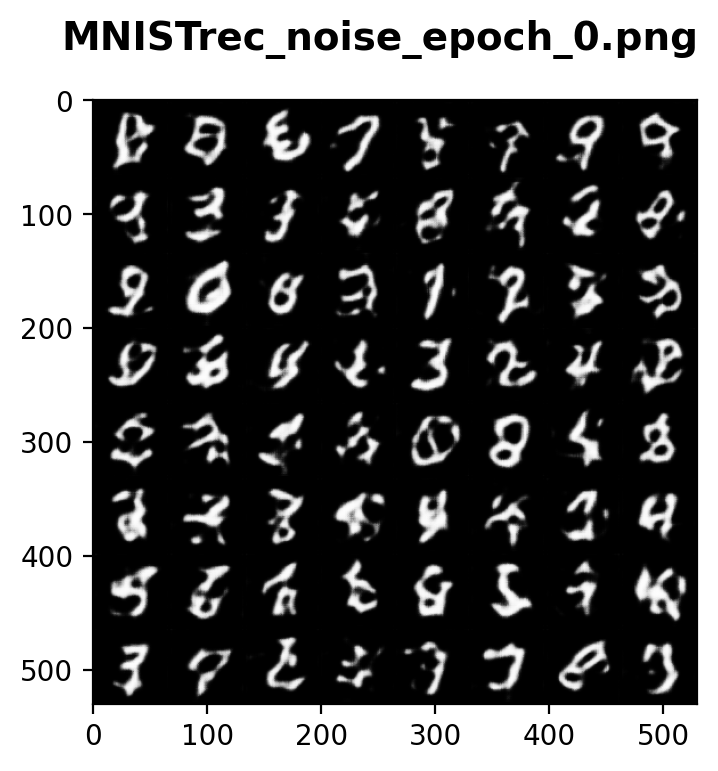

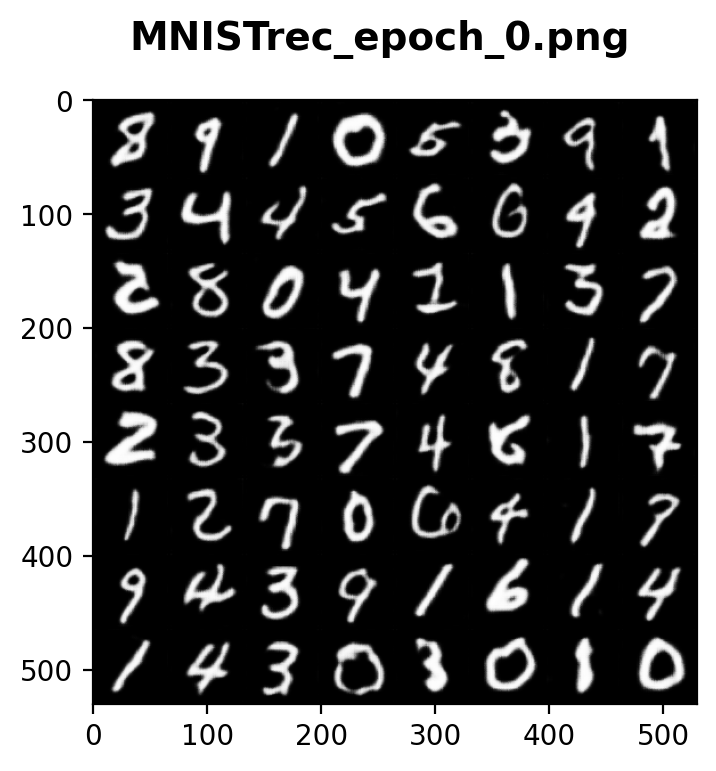

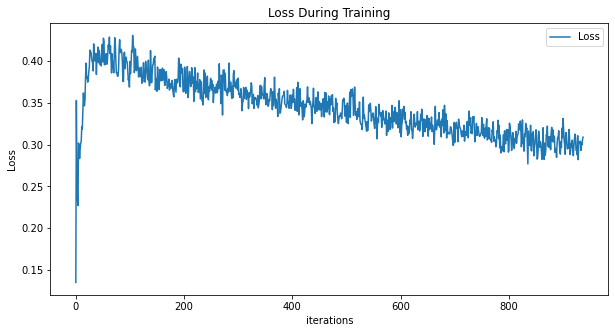

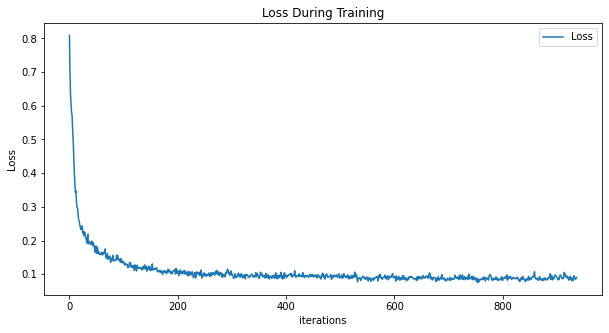

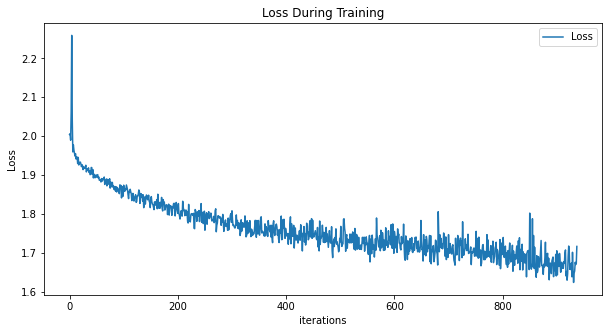

In [ ]:
data_loader=dataloader(64)
train_VAE_GAN(lr=0.0003, data_loader=dataloader, model_name="VAE_GAN_model_lr=3e-4")

## Learning Rate = 0.0006 (Double)

[0/1][0/938]	Loss_gan: 1.7710	Loss_prior: 0.1326	Rec_loss: 0.7350	dis_real_loss: 0.6693	dis_fake_loss: 0.5516	dis_prior_loss: 0.5501
[0/1][1/938]	Loss_gan: 1.7922	Loss_prior: 0.5349	Rec_loss: 0.6718	dis_real_loss: 0.6549	dis_fake_loss: 0.5705	dis_prior_loss: 0.5668
[0/1][2/938]	Loss_gan: 1.9435	Loss_prior: 0.2882	Rec_loss: 0.6450	dis_real_loss: 0.6810	dis_fake_loss: 0.6646	dis_prior_loss: 0.5979
[0/1][3/938]	Loss_gan: 3.0903	Loss_prior: 0.3116	Rec_loss: 0.6440	dis_real_loss: 0.7795	dis_fake_loss: 1.2159	dis_prior_loss: 1.0949
[0/1][4/938]	Loss_gan: 1.9375	Loss_prior: 37.4714	Rec_loss: 0.6360	dis_real_loss: 0.7355	dis_fake_loss: 0.5168	dis_prior_loss: 0.6852
[0/1][5/938]	Loss_gan: 1.9389	Loss_prior: 24.1828	Rec_loss: 0.6581	dis_real_loss: 0.7177	dis_fake_loss: 0.5737	dis_prior_loss: 0.6474
[0/1][6/938]	Loss_gan: 2.2681	Loss_prior: 0.3107	Rec_loss: 0.6278	dis_real_loss: 0.7094	dis_fake_loss: 0.7464	dis_prior_loss: 0.8122
[0/1][7/938]	Loss_gan: 2.1684	Loss_prior: 0.2780	Rec_loss: 0.5990	d

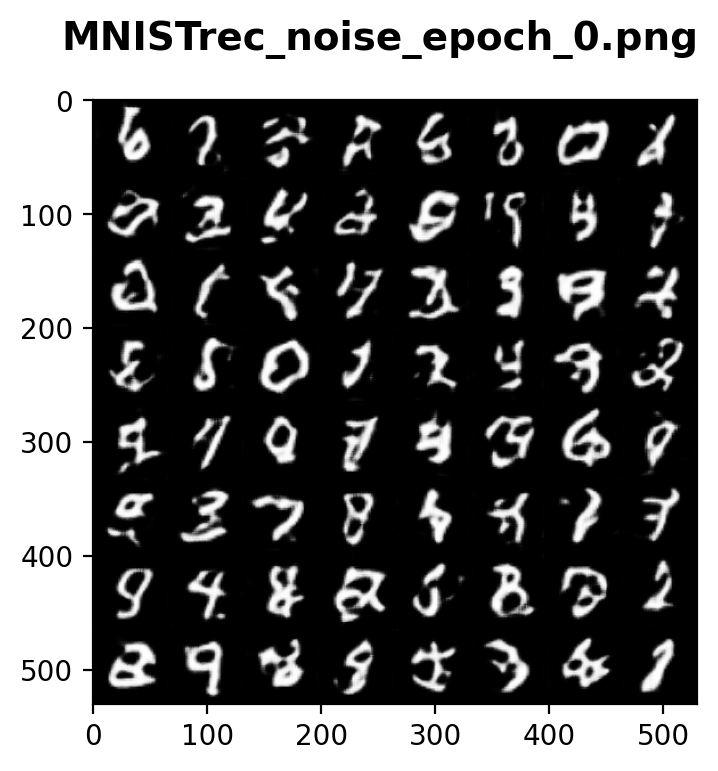

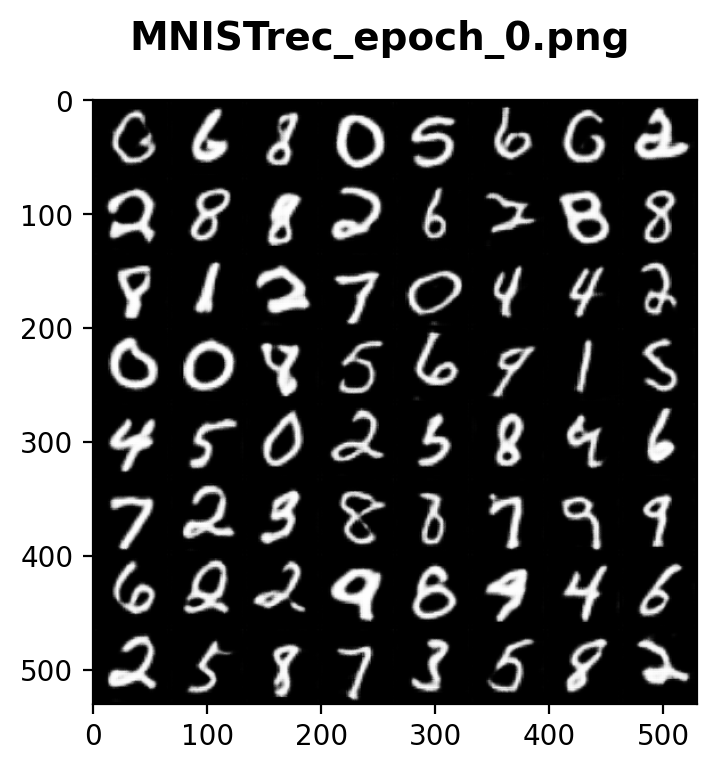

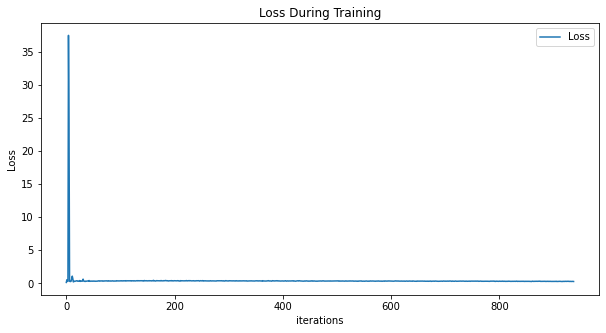

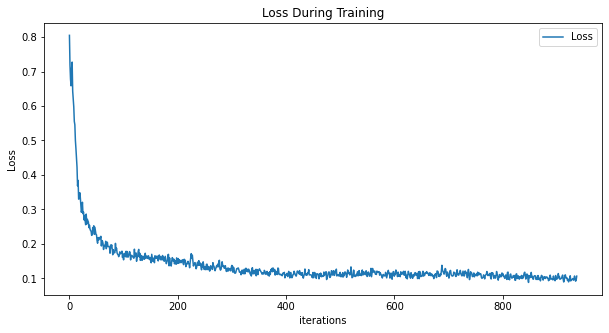

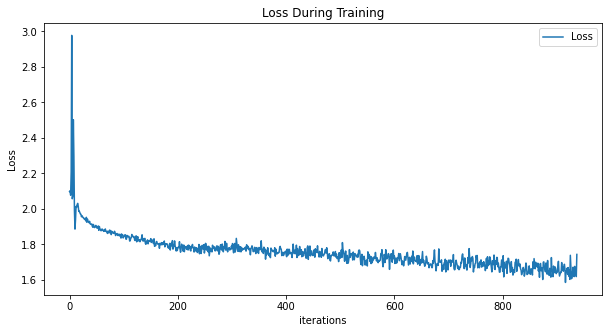

In [ ]:
train_VAE_GAN(lr=0.0006, data_loader=dataloader, model_name="VAE_GAN_model_lr=6e-4")

## Learning Rate = 0.00015 (Half)

[0/1][0/938]	Loss_gan: 2.0373	Loss_prior: 0.1313	Rec_loss: 0.7754	dis_real_loss: 0.6102	dis_fake_loss: 0.7128	dis_prior_loss: 0.7143
[0/1][1/938]	Loss_gan: 2.0678	Loss_prior: 0.1735	Rec_loss: 0.7398	dis_real_loss: 0.6189	dis_fake_loss: 0.7253	dis_prior_loss: 0.7237
[0/1][2/938]	Loss_gan: 2.0673	Loss_prior: 0.1752	Rec_loss: 0.7137	dis_real_loss: 0.6190	dis_fake_loss: 0.7264	dis_prior_loss: 0.7219
[0/1][3/938]	Loss_gan: 2.0716	Loss_prior: 0.1655	Rec_loss: 0.6882	dis_real_loss: 0.6252	dis_fake_loss: 0.7186	dis_prior_loss: 0.7278
[0/1][4/938]	Loss_gan: 2.0775	Loss_prior: 0.1535	Rec_loss: 0.6673	dis_real_loss: 0.6242	dis_fake_loss: 0.7259	dis_prior_loss: 0.7274
[0/1][5/938]	Loss_gan: 2.0669	Loss_prior: 0.1473	Rec_loss: 0.6532	dis_real_loss: 0.6222	dis_fake_loss: 0.7257	dis_prior_loss: 0.7190
[0/1][6/938]	Loss_gan: 2.0644	Loss_prior: 0.1357	Rec_loss: 0.6402	dis_real_loss: 0.6249	dis_fake_loss: 0.7176	dis_prior_loss: 0.7219
[0/1][7/938]	Loss_gan: 2.0745	Loss_prior: 0.1284	Rec_loss: 0.6218	dis

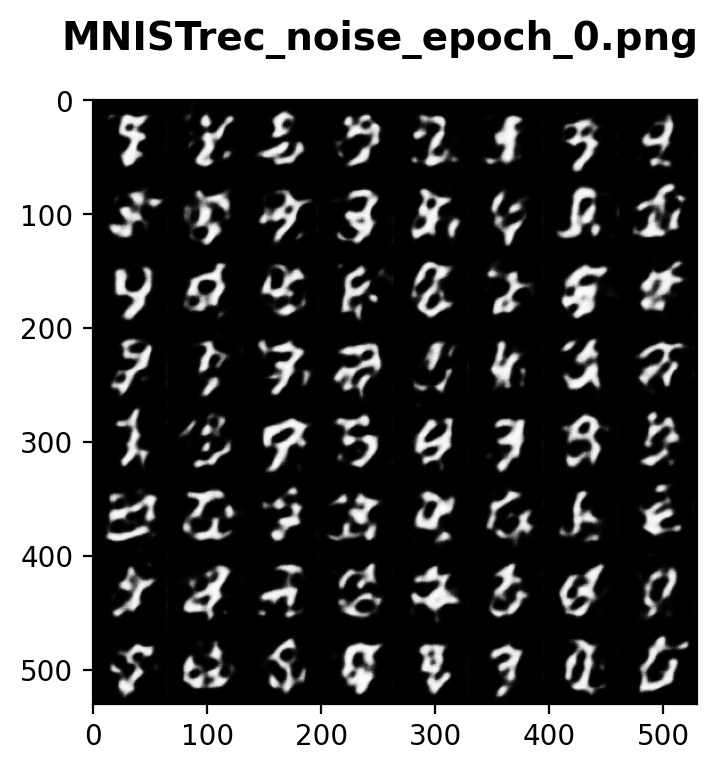

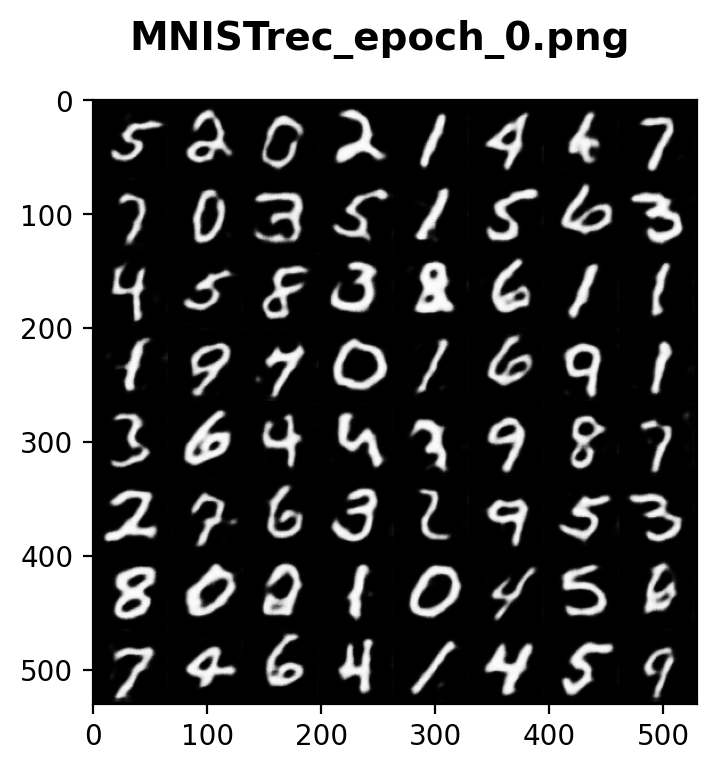

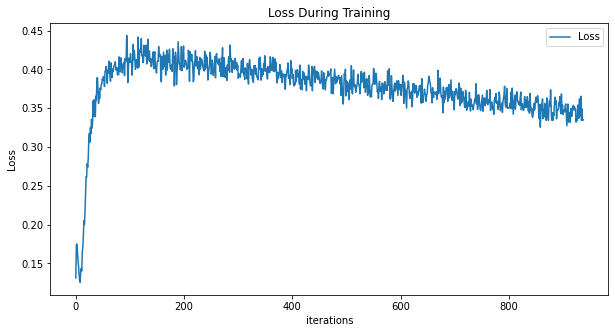

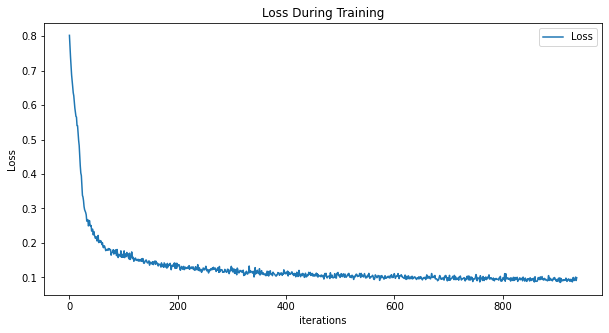

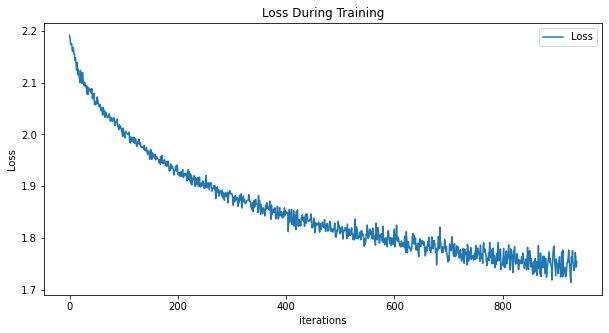

In [ ]:
train_VAE_GAN(lr=0.00015, data_loader=dataloader, model_name="VAE_GAN_model_lr=15e-5")